**Small Sample Simulation for Bottling Factory Machine**


Credit goes to Paul Grogan's works on *SimPy*. We are under the assumption that everything starts at the same time for this small scale bottling company.

In [17]:
!pip install simpy

In [0]:
import simpy
import numpy as np

In [0]:
def factory_run(env, staff, spares):
    
    global cost
    cost = 0.0

    # we need to manage the machines. so we have 2 running at the moment.
    for i in range(2):
      env.process(operate_machine(env, staff, spares))

    # recurring loop of costs incurred from staff and cost of machine. value converted to PHP.
    # 250 per hour for an engineer who work for 6 hours and we have two. we are assuming that the machine for a small scale bottling facility costs 833 per day.
    while True:
      cost += 250*6*staff.capacity + 833*spares.capacity
      yield env.timeout(8.0)

def operate_machine(env, staff, cans):      
    
    global cost

    while True:
      yield env.timeout(time_to_failure())
      t_broken = env.now
      print('{:.2f} machine broke'.format(t_broken))
      # repair machine and log time.
      # putting this statement means we don't have to wait for the repair, we just launch it.
      env.process(repair_machine(env, staff, spares))
      yield spares.get(1)
      t_replaced = env.now
      print('{:.2f} machine replaced'.format(t_replaced))
      cost += 550*(t_replaced - t_broken) # 550 is the cost per hour of not having the machine 

# determine distribution of hours to complete repair.
def generate_repair_time():
    return np.random.uniform(9, 11)    


# breaks every x. in our case every 10 days.
def time_to_failure():
    return np.random.uniform(240, 480)

# define repair machine. put back cans from our pool of cans.
def repair_machine(env, staff, spares): 
    with staff.request() as request:
      yield request
      yield env.timeout(generate_repair_time())
      yield spares.put(1)
    print('{:.2f} machine repaired'.format(env.now))  




In [0]:
# generate data for plotting
observation_times = []
observation_cost = []
number_of_spares = []

In [0]:
def observe(env, cans):
  while True:
    observation_times.append(env.now)
    # be careful to define global cost. for this type of simulation it works fine.
    observation_cost.append(cost)
    number_of_spares.append(spares.level) # to know how many levels of spares are available.
    yield env.timeout(1.0) # process monitor takes place every one hour.


In [0]:
np.random.seed(42)

In [0]:
env = simpy.Environment()

In [0]:
staff = simpy.Resource(env, capacity=2)

In [0]:
# we are assuming that there are 2 spare machines. 
spares = simpy.Container(env, init=2, capacity=2)

In [26]:
env.process(factory_run(env, staff, spares))

<Process(factory_run) object at 0x7f51c2c44be0>

In [27]:
env.process(observe(env, spares))

<Process(observe) object at 0x7f51c2c44358>

In [28]:
# the assumption is that the machines run for 12 hours a day. the numbers reflected here is based on weeks. 
# we chose a random period within week 10 - 20 (240 - 480).
env.run(until=12*5*52)

329.89 machine broke
329.89 machine replaced
340.09 machine repaired
468.17 machine broke
468.17 machine replaced
477.48 machine repaired
745.57 machine broke
745.57 machine replaced
745.62 machine broke
745.62 machine replaced
756.03 machine repaired
756.30 machine repaired
999.51 machine broke
999.51 machine replaced
1010.45 machine repaired
1129.88 machine broke
1129.88 machine replaced
1139.31 machine repaired
1244.45 machine broke
1244.45 machine replaced
1253.82 machine repaired
1528.09 machine broke
1528.09 machine replaced
1538.14 machine repaired
1569.67 machine broke
1569.67 machine replaced
1579.25 machine repaired
1841.10 machine broke
1841.10 machine replaced
1850.38 machine repaired
1913.34 machine broke
1913.34 machine replaced
1923.07 machine repaired
2223.45 machine broke
2223.45 machine replaced
2227.95 machine broke
2227.95 machine replaced
2234.02 machine repaired
2237.98 machine repaired
2515.87 machine broke
2515.87 machine replaced
2524.96 machine repaired
2572.9

In [30]:
observation_cost[-1]

1819740.0

This is our final cost.

Text(0, 0.5, 'spares')

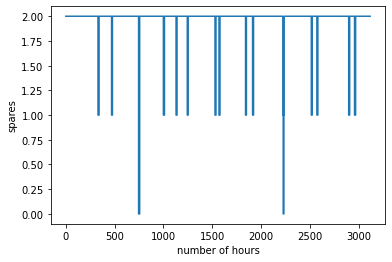

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.step(observation_times, number_of_spares, where='post')
plt.xlabel("number of hours")
plt.ylabel("spares")

So in around hours 750 and 2250 hours (30 and 94 days respectively), we are out of spare machines, but it will still be replenished as soon as its available.

Text(0, 0.5, 'cost')

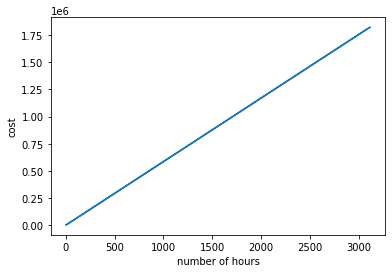

In [32]:

plt.figure()
plt.step(observation_times, observation_cost, where='post')
plt.xlabel("number of hours")
plt.ylabel("cost")